In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
car_df = pd.read_csv('clean_signals.csv')

car_df['timestamp'] = pd.to_datetime(car_df['timestamp'])

car_df.shape

(1953951, 20)

In [3]:
target_cols = ['device_id', 'trip_id', 'timestamp', 'speed', 'acc_x', 'acc_y', 'acc_z']

In [4]:
complete_driving_df = car_df[car_df['is_complete'] == True][target_cols]
    
complete_driving_df.head()

,device_id,trip_id,timestamp,speed,acc_x,acc_y,acc_z
183104,1,1,2018-01-24 19:48:01,3,-0.023588,-0.061869,-0.044745
183105,1,1,2018-01-24 19:48:02,2,-0.261130,-0.781108,-0.566984
183106,1,1,2018-01-24 19:48:03,0,-0.252172,-0.782251,-0.586721
183107,1,1,2018-01-24 19:48:04,0,-0.251845,-0.809530,-0.538245
183108,1,1,2018-01-24 19:48:05,0,-0.229758,-0.806974,-0.552653


In [5]:
def device_driving_history(df):

    df['day_of_the_month'] = df['timestamp'].dt.day.astype(str)

    return df[['device_id', 'day_of_the_month']]\
        .drop_duplicates()\
        .groupby(['device_id'])\
        .agg({'day_of_the_month': lambda x: ', '.join(x.values)})

device_driving_history(complete_driving_df.copy())

,day_of_the_month
device_id,
1,"24, 25"
2,"16, 19, 20, 21"
3,"11, 12, 21, 28, 31"
5,"10, 12, 13, 15, 16, 17, 19, 20, 22"
6,"29, 31"
7,"12, 16, 18, 21, 30"
8,29
10,"1, 3, 9, 13, 19, 20, 28, 29, 30"
11,31


In [6]:
def extract_driving_period(df):
    
    driving_period_list = list()
    
    for i, ((device_id, trip_id), group_df) in enumerate(df.groupby(['device_id', 'trip_id'])):
        group_df = group_df.reset_index(drop=True)\
            .reset_index()\
            .rename(columns={'index': 'time_step'})

        # Drop the first record to smooth the signals
        group_df = group_df.loc[1:]

        # Fine the time before stopping the card. 
        driving_time_index = group_df[group_df['speed'] > 0]
        time_before_driving = driving_time_index.index.min()
        time_before_stop = driving_time_index.index.max()
        
        # Remove the records of stopping.
        group_df = group_df.loc[np.maximum(0, time_before_driving-5): time_before_stop+5]
        
        if ~np.isnan(time_before_stop) and group_df.shape[0] > 50:
            driving_period_list.append(group_df)
            
    return pd.concat(driving_period_list, ignore_index=True)

In [10]:
driving_df = extract_driving_period(complete_driving_df)

In [8]:
def plot_driving_period(df):
    for i, ((device_id, trip_id), group_df) in enumerate(df.groupby(['device_id', 'trip_id'])):
        group_df = group_df.reset_index(drop=True).reset_index()

        plt.figure()
        _, axes = plt.subplots(2, 1, figsize=(12, 4))
        sns.lineplot(x=group_df['index'], y=group_df['acc_x'], ax=axes[0], color='blue')\
            .set_title('Device id: {} | Trip id: {}'.format(device_id, trip_id))
        sns.lineplot(x=group_df['index'], y=group_df['acc_y'], ax=axes[0], color='green')
        sns.lineplot(x=group_df['index'], y=group_df['acc_z'], ax=axes[0], color='red') 
        sns.lineplot(x=group_df['index'], y=group_df['speed'], ax=axes[1], color='grey')  
    
#     if i == 2: break

/var/folders/wj/kg65sk251rz1g4h8_694mm9r0000gn/T/ipykernel_41741/1729642384.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

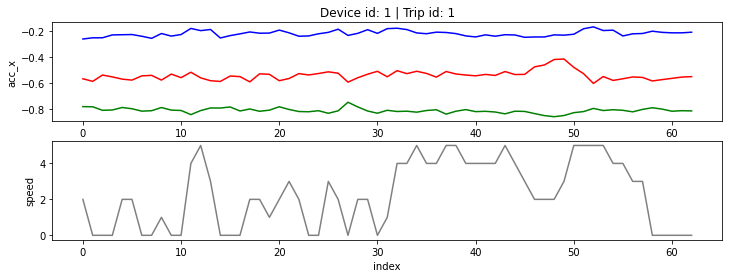

<Figure size 432x288 with 0 Axes>

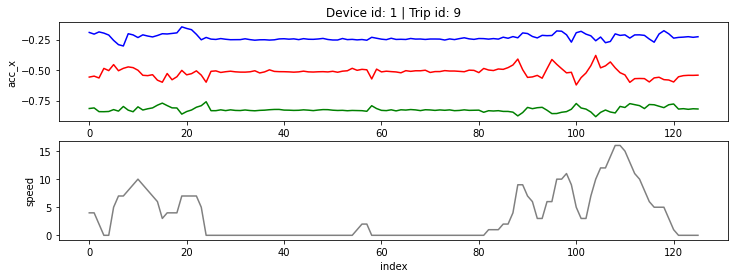

<Figure size 432x288 with 0 Axes>

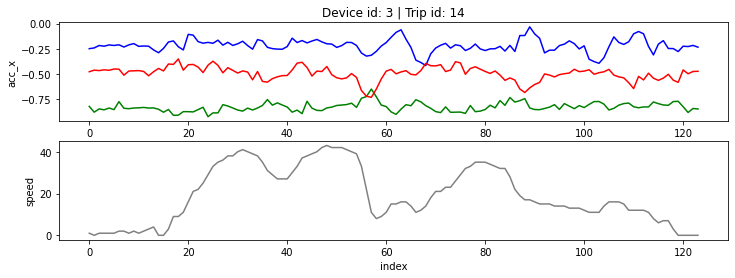

<Figure size 432x288 with 0 Axes>

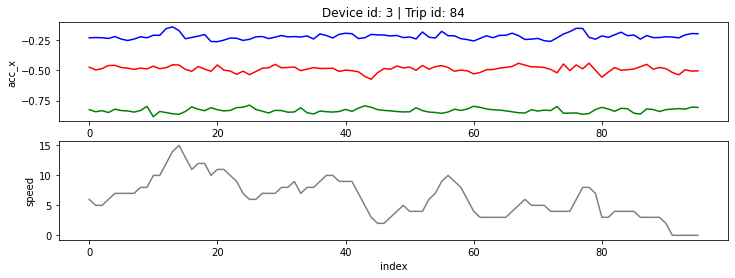

<Figure size 432x288 with 0 Axes>

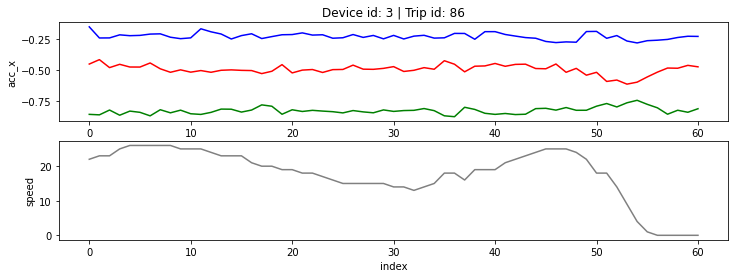

<Figure size 432x288 with 0 Axes>

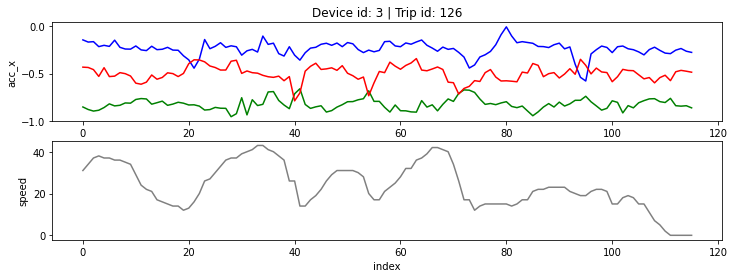

<Figure size 432x288 with 0 Axes>

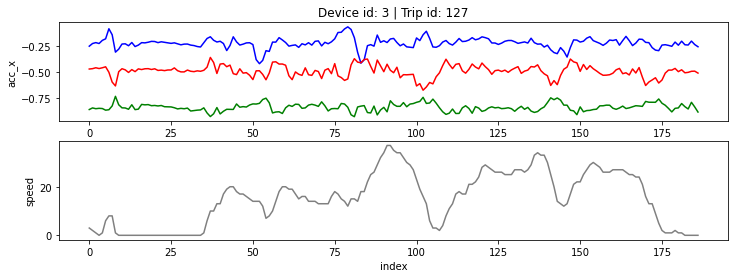

<Figure size 432x288 with 0 Axes>

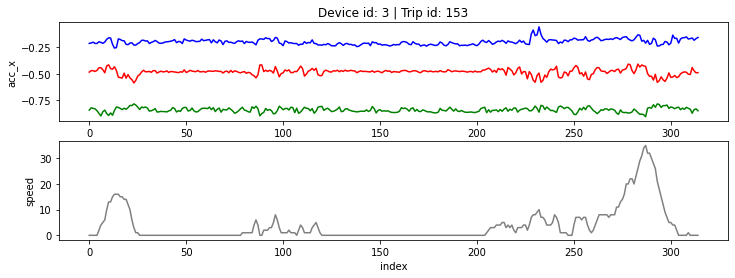

<Figure size 432x288 with 0 Axes>

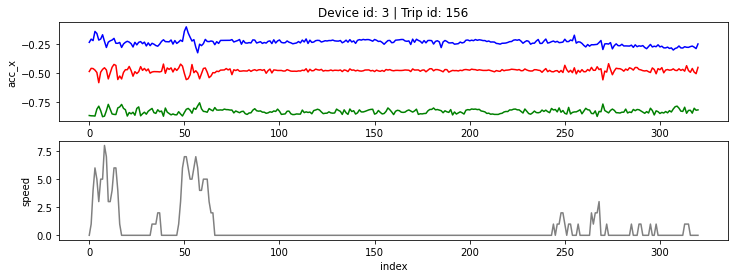

<Figure size 432x288 with 0 Axes>

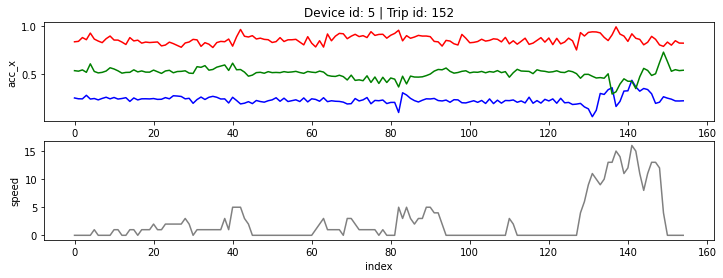

<Figure size 432x288 with 0 Axes>

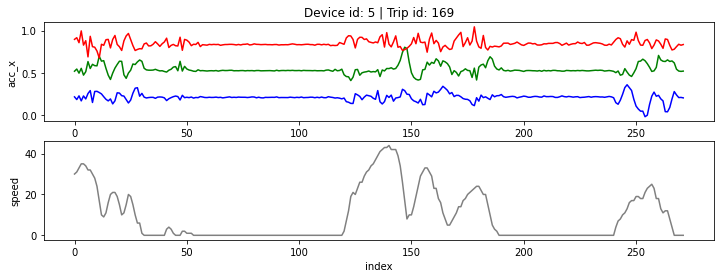

<Figure size 432x288 with 0 Axes>

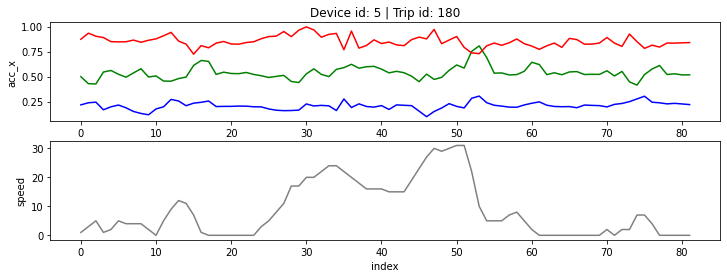

<Figure size 432x288 with 0 Axes>

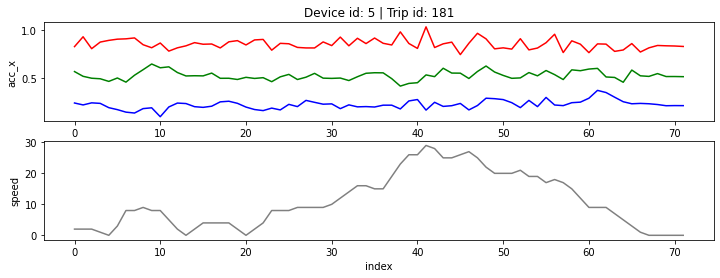

<Figure size 432x288 with 0 Axes>

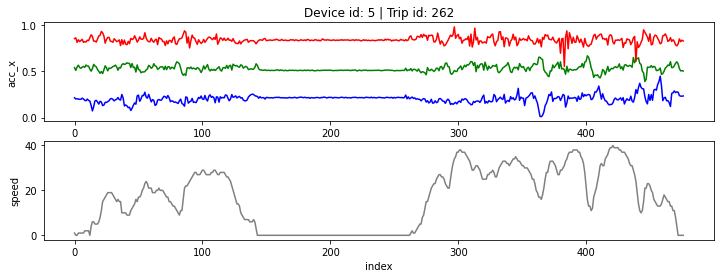

<Figure size 432x288 with 0 Axes>

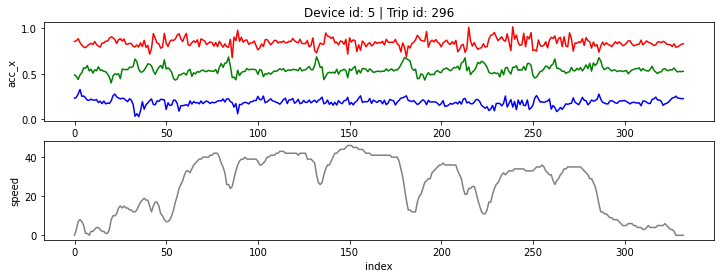

<Figure size 432x288 with 0 Axes>

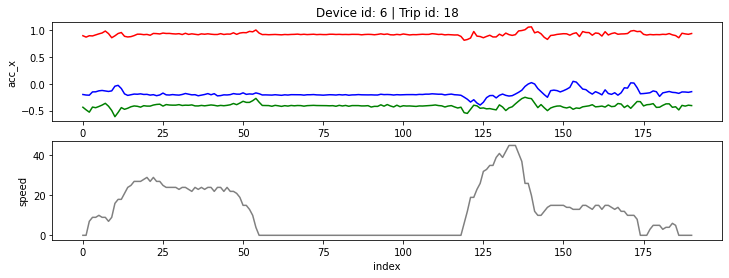

<Figure size 432x288 with 0 Axes>

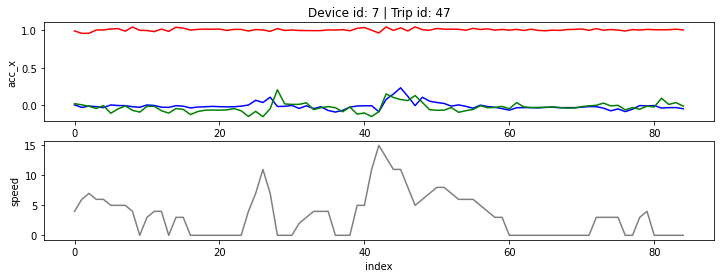

<Figure size 432x288 with 0 Axes>

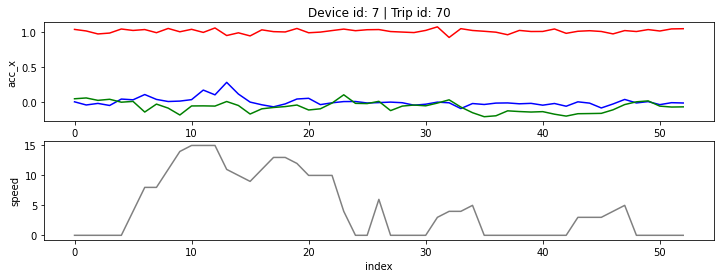

<Figure size 432x288 with 0 Axes>

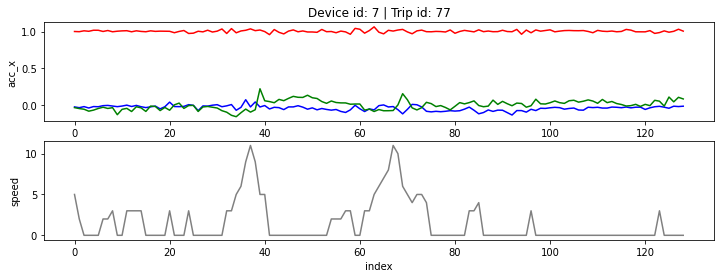

<Figure size 432x288 with 0 Axes>

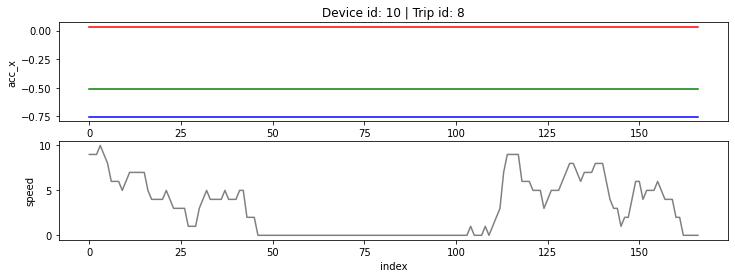

<Figure size 432x288 with 0 Axes>

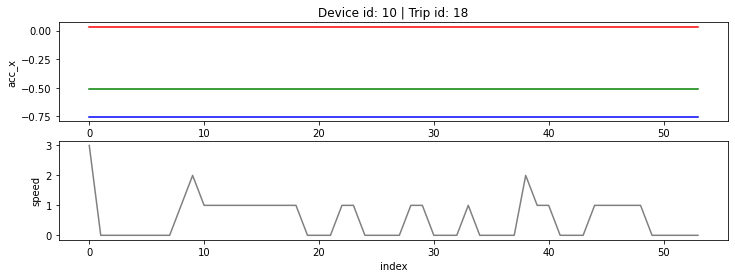

<Figure size 432x288 with 0 Axes>

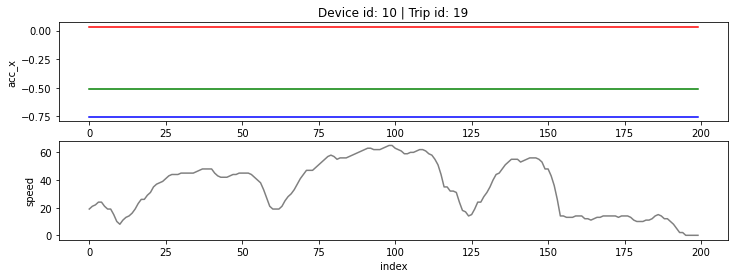

<Figure size 432x288 with 0 Axes>

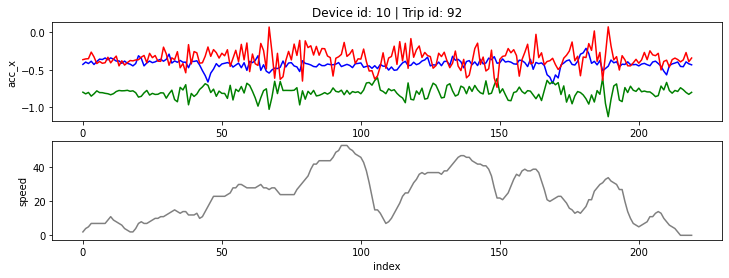

<Figure size 432x288 with 0 Axes>

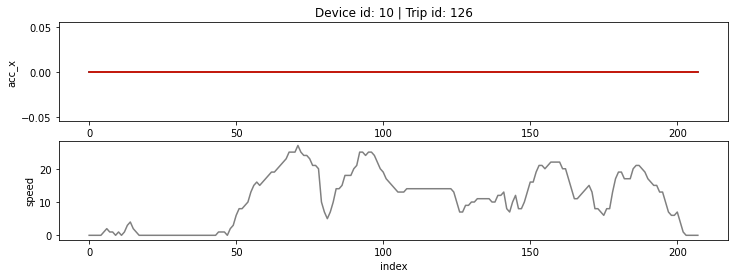

<Figure size 432x288 with 0 Axes>

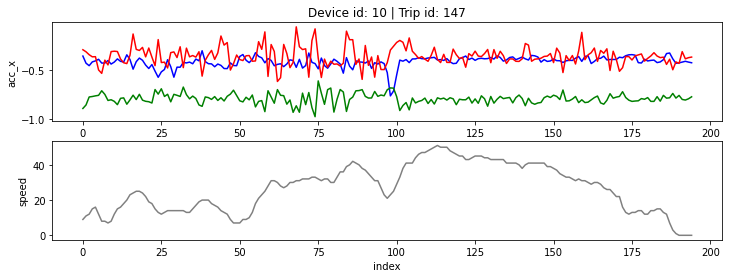

<Figure size 432x288 with 0 Axes>

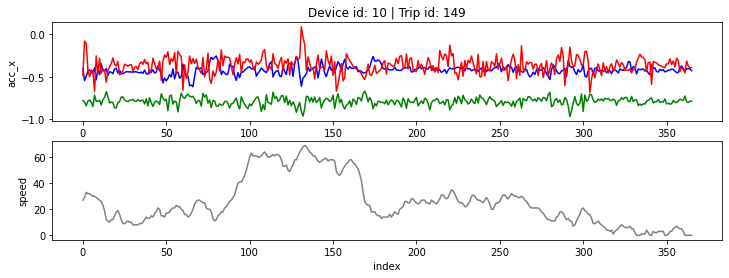

<Figure size 432x288 with 0 Axes>

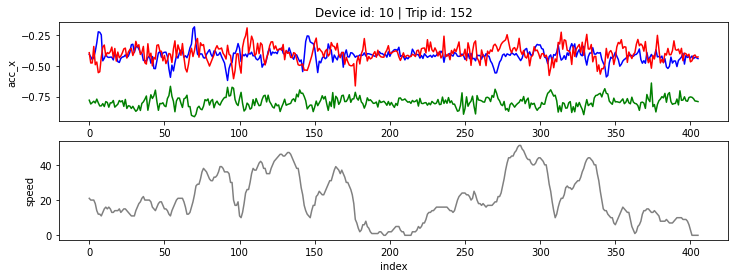

<Figure size 432x288 with 0 Axes>

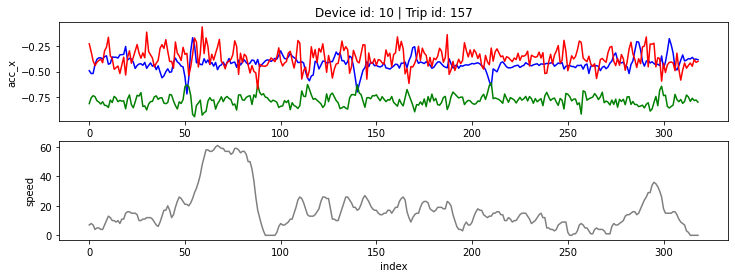

<Figure size 432x288 with 0 Axes>

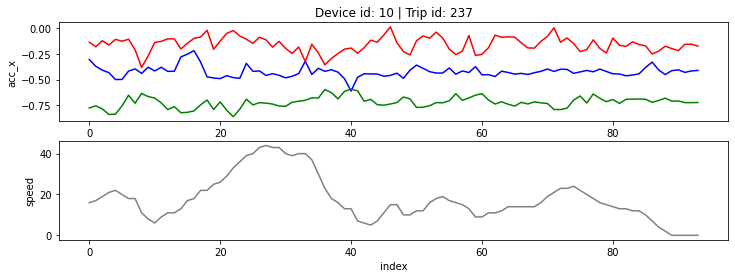

<Figure size 432x288 with 0 Axes>

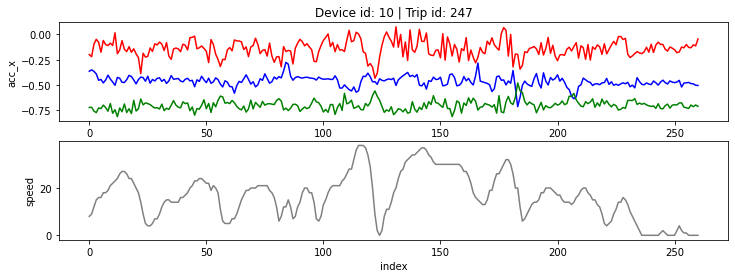

<Figure size 432x288 with 0 Axes>

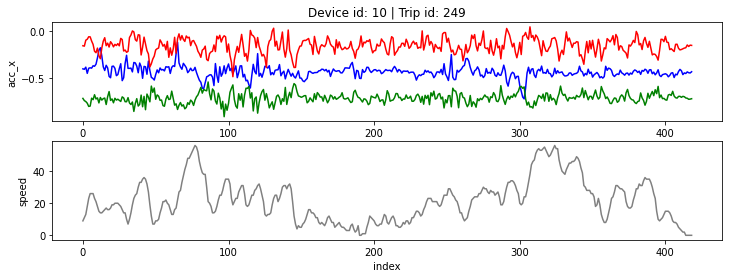

<Figure size 432x288 with 0 Axes>

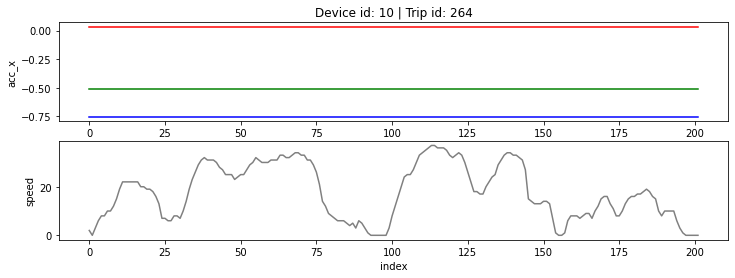

<Figure size 432x288 with 0 Axes>

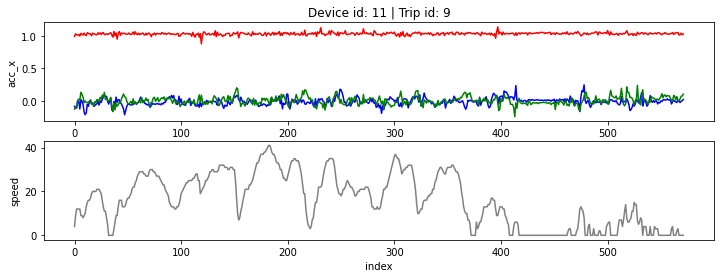

In [11]:
plot_driving_period(driving_df)

### Deceleration analysis

### Trip analysis
- number of unique trips
- trip duration distribution
- trips per car
- drive speed analysis (overspeeding) time spent on each speed bucket
- time of idling with engine on per trip

#### Behavior Analysis
- trips completed per user
- total drive time per user
- drive time per trip
- trip distance
- trip history?


- day driving time vs. night driving time (night time can be 11pm to 4am)
- day driving is safter than night driving


- hardbrakes
- rash acceleration (hard accelerate)
- drive speed (km/hr), overspeeding
- idling with engine on (idling on a public road is dangerous. idling is not environmental friendly and burns the same amount of oil as driving.)

#### Customer Segmentation
Build driving behavior features for clustering, and analyse the commonality in each group. But customer profiling with more meaningful background information can make features more representative.

Beside, we don't have any customer information in the data.

#### Customer Safety Analysis
Some customers are more risky while driving. It causes a high chance to car accidents. It impacts car availability.

In [14]:
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

/opt/homebrew/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [36]:
X = car_df[obd_sensors_cols].drop('diagnostic_trouble_code', axis=1)
y = car_df['diagnostic_trouble_code'].values

In [37]:
X.shape, y.shape

((1953951, 12), (1953951,))

In [38]:
car_df['diagnostic_trouble_code'].unique()

array([0, 2, 1])

In [39]:
sum(y == 129), sum(y == 67)

(0, 0)

In [40]:
y[y == 0] = 0
y[y == 129] = 1
y[y == 67] = 2

In [41]:
set(y)

{0, 1, 2}

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
clf = XGBClassifier(n_estimators=300,
                     max_depth=5,
                     max_leaves=64,
                     eta=0.1,
                     reg_lambda=0,
                     tree_method='hist',
                     eval_metric='logloss',
                     use_label_encoder=False,
                     random_state=42,
                     n_jobs=-1)

# clf.fit(X_train,y_train)
# y_pred = clf.predict(X_train)
# print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.4f}')

clf.fit(X, y)
y_pred = clf.predict(X)
print(f'Test Accuracy: {accuracy_score(y, y_pred):.4f}')

/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Test Accuracy: 1.0000


Text(0.5, 0, 'Xgboost Feature Importance')

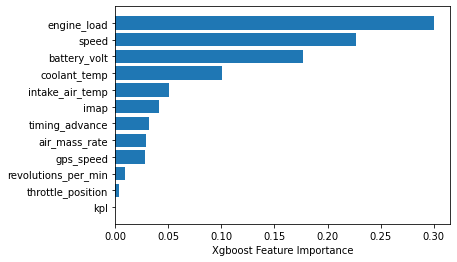

In [44]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], 
         clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

<AxesSubplot:>

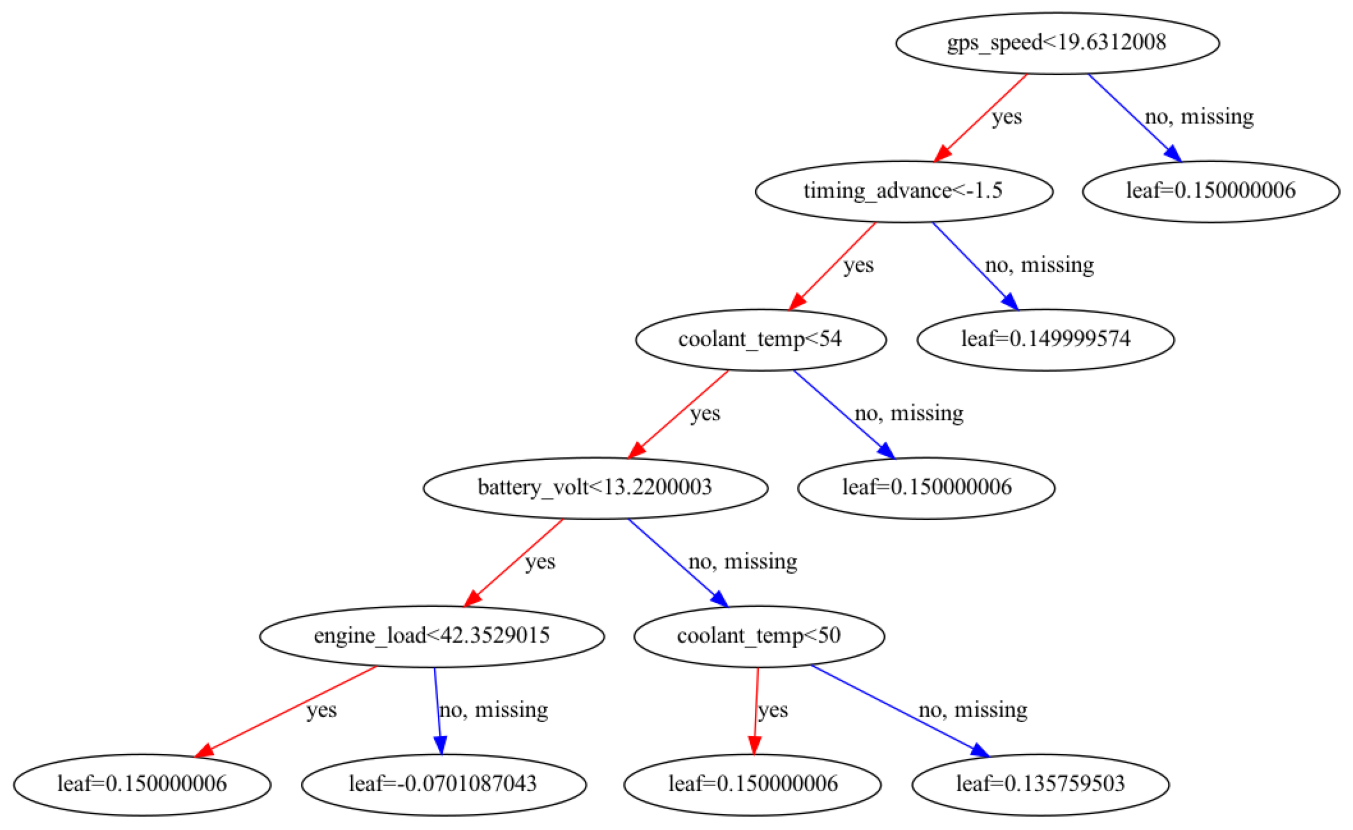

In [45]:
fig, ax = plt.subplots(figsize=(24, 32))
plot_tree(clf, ax=ax)

# plt.show()

In [46]:
labels = [0, 1, 2]
confusion_matrix = confusion_matrix(y, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths = 0.1, fmt="d", cmap = "YlGnBu")
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

TypeError: 'numpy.ndarray' object is not callable

In [31]:
1/(1+np.exp(-1*0.15)), 1/(1+np.exp(-1*-0.069))

(0.5374298453437496, 0.48275684068067043)